### Import libraries

In [2]:
import requests, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


### Set variables

In [3]:
url = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(url + '?fsym=BTC&tsym=AUD&limit=2000')

### Import data

In [4]:
hist = pd.DataFrame(json.loads(res.content)['Data'])
bitcoin = hist.set_index('time')
bitcoin.index = pd.to_datetime(bitcoin.index, unit='s')
bitcoin = bitcoin[bitcoin.index >='2018-01-01']

In [5]:
bitcoin[1:10]

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2018-01-02,19826.75,20363.05,18313.80,18361.44,748.64,14290127.97
2018-01-03,21119.92,21277.03,19798.76,19826.75,744.14,15373658.57
2018-01-04,21145.63,21850.88,19986.66,21214.38,930.36,19490102.69
2018-01-05,22833.21,23763.15,20774.61,21019.23,1701.14,37650316.92
2018-01-06,22892.65,23491.77,21990.14,22833.21,1069.09,23896103.68
2018-01-07,22862.21,23473.61,21379.81,22844.09,3203.37,70848367.68
2018-01-08,21780.06,23152.18,20465.40,22862.21,1414.26,30874112.21
2018-01-09,20626.33,22983.93,20316.07,21780.06,1198.92,25779542.72
2018-01-10,20975.65,21329.40,20175.93,20634.05,1145.57,23656538.97


### Convert data to relevant format

In [6]:
bitcoin_array = pd.DataFrame(bitcoin["close"]).values
bitcoin_array = bitcoin_array.astype("float64")
bitcoin_array.shape

(256, 1)

### Normalise bitcoin data

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
bitcoin_array = scaler.fit_transform(bitcoin_array)
bitcoin_array[1:10]

array([[0.79385845],
       [0.88080717],
       [0.88253583],
       [0.99600344],
       [1.        ],
       [0.99795331],
       [0.92519292],
       [0.84761971],
       [0.8711069 ]])

In [8]:
len(bitcoin_array)

256

### Create train and test set

80% is used for training, 20% is used for testing.

<font color='red'>I think test data should not be 7. what do others think??? But it is time series, it can't be shuffled with 20% test and 80% train, but other people did use 20% or something too, so bit confused here. </font>

In [9]:
prop = 0.2
test_threshold = round(len(bitcoin_array)*prop)
max_threshold = round(len(bitcoin_array)*(1-prop))
print (test_threshold,max_threshold)

51 205


In [10]:
train = bitcoin_array[(len(bitcoin_array)-max_threshold-test_threshold):(len(bitcoin_array)-test_threshold)]
test = bitcoin_array[(len(bitcoin_array)-test_threshold):]

In [11]:
print (train.shape)
print (test.shape)

(205, 1)
(51, 1)


### Create window function

Function creates arrays which look at previous `x` values.

Note window can be updated.

In [12]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        dataX.append(dataset[i:(i+look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

### look_back = 1

In [13]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [14]:
print (trainX.shape, testX.shape)

(203, 1) (49, 1)


input_shape: 3D tensor with shape (batch_size, timesteps, input_dim)

In [15]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

### Build LSTM model

In [16]:
from keras.layers import Dropout

In [17]:
batch_size = 10
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(1, 1)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))
lstm_model.compile(loss="mean_squared_error", optimizer="adam")
lstm_model.fit(trainX, trainY, epochs=30, batch_size=batch_size, verbose=2)

Epoch 1/30
 - 1s - loss: 0.0797
Epoch 2/30
 - 0s - loss: 0.0519
Epoch 3/30
 - 0s - loss: 0.0365
Epoch 4/30
 - 0s - loss: 0.0289
Epoch 5/30
 - 0s - loss: 0.0237
Epoch 6/30
 - 0s - loss: 0.0230
Epoch 7/30
 - 0s - loss: 0.0229
Epoch 8/30
 - 0s - loss: 0.0198
Epoch 9/30
 - 0s - loss: 0.0178
Epoch 10/30
 - 0s - loss: 0.0180
Epoch 11/30
 - 0s - loss: 0.0137
Epoch 12/30
 - 0s - loss: 0.0104
Epoch 13/30
 - 0s - loss: 0.0114
Epoch 14/30
 - 0s - loss: 0.0103
Epoch 15/30
 - 0s - loss: 0.0097
Epoch 16/30
 - 0s - loss: 0.0074
Epoch 17/30
 - 0s - loss: 0.0062
Epoch 18/30
 - 0s - loss: 0.0053
Epoch 19/30
 - 0s - loss: 0.0046
Epoch 20/30
 - 0s - loss: 0.0049
Epoch 21/30
 - 0s - loss: 0.0034
Epoch 22/30
 - 0s - loss: 0.0034
Epoch 23/30
 - 0s - loss: 0.0039
Epoch 24/30
 - 0s - loss: 0.0043
Epoch 25/30
 - 0s - loss: 0.0030
Epoch 26/30
 - 0s - loss: 0.0043
Epoch 27/30
 - 0s - loss: 0.0031
Epoch 28/30
 - 0s - loss: 0.0033
Epoch 29/30
 - 0s - loss: 0.0031
Epoch 30/30
 - 0s - loss: 0.0030


In [18]:
trainScore = lstm_model.evaluate(trainX, trainY, batch_size=batch_size, verbose=0)
print('Train Score: ', trainScore)
testScore = lstm_model.evaluate(testX[:252], testY[:252], batch_size=batch_size, verbose=0)
print('Test Score: ', testScore)

Train Score:  0.0021590410631088072
Test Score:  0.00045000363811874305


bench mark: 
Train Score: 408.17 RMSE
Test Score: 527.92 RMSE

In [19]:
# Make predictions.
trainPredict = lstm_model.predict(trainX)
testPredict = lstm_model.predict(testX)

# Invert predictions, transform back to equivalent bitcoin prices.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error.
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 691.07 RMSE
Test Score: 315.50 RMSE


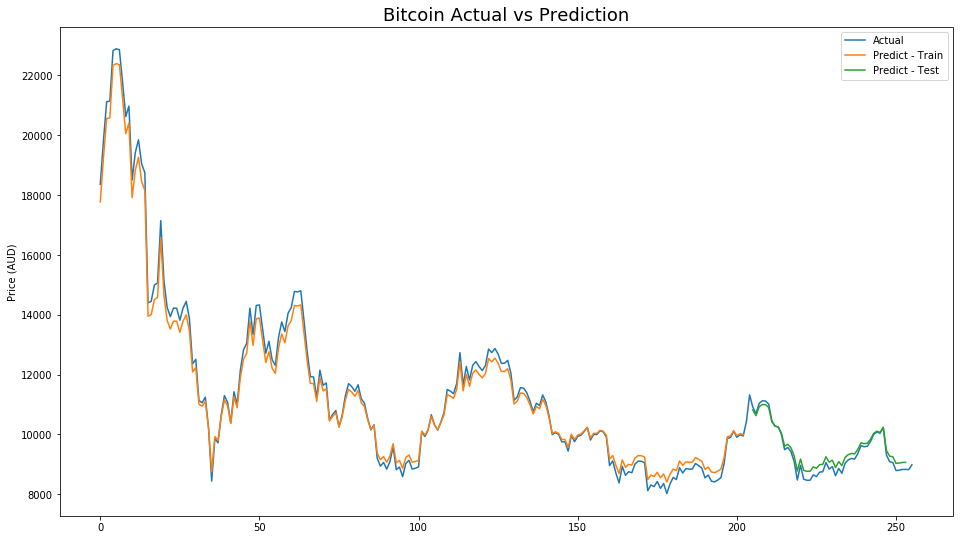

In [20]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(bitcoin_array)
trainPredictPlot[:, :] = np.nan
for i in range(0, len(trainPredict), 1):
    trainPredictPlot[(len(bitcoin_array)-max_threshold-test_threshold)+i] = trainPredict[i]
testPredictPlot = np.empty_like(bitcoin_array)
testPredictPlot[:, :] = np.nan
for i in range(0, len(testPredict), 1):
    testPredictPlot[(len(bitcoin_array)-test_threshold)+i] = testPredict[i]

# Revert back to relevant periods
bitcoin_array_plot = bitcoin_array[(len(bitcoin_array)-max_threshold-test_threshold):len(bitcoin_array)]
trainPredictPlot = trainPredictPlot[(len(trainPredictPlot)-max_threshold-test_threshold):]
testPredictPlot = testPredictPlot[(len(testPredictPlot)-max_threshold-test_threshold):]
plt.subplots(figsize=(16,9))
plt.plot(scaler.inverse_transform(bitcoin_array_plot), label="Actual")
plt.plot(trainPredictPlot, label="Predict - Train")
plt.plot(testPredictPlot, label="Predict - Test")
plt.title("Bitcoin Actual vs Prediction", fontsize=18); plt.xlabel(""); plt.ylabel("Price (AUD)")
plt.legend(loc="upper right")
plt.show()

We observe that **LSTM** follows the overall pattern of bitcoin prices quite well, albeit our root mean square error appears high. However as there is high volatility with large fluctuations in price, we can assume the model predicts quite well for future bitcoin prices.

Model can be improved by changing the following parameters:

* Update window function.
* Increasing number of epochs.
* Changing hidden layer structure.
* For good predictive model the RMSE values should be <0.3.

#### Stacked LSTM model with window size 30

Test model above with window of size 30.

In [21]:
# Define window.
look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print (trainX.shape, testX.shape)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
print (trainX.shape, testX.shape)

(194, 10) (40, 10)
(194, 10, 1) (40, 10, 1)


In [22]:
batch_size = 1
model = Sequential()
model.add(LSTM(32,input_dim=1))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=30, batch_size=batch_size, verbose=2)

/Users/libaisun/virtual/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/libaisun/virtual/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(32, input_shape=(None, 1))`
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/libaisun/virtual/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/30
 - 4s - loss: 0.0139
Epoch 2/30
 - 2s - loss: 0.0068
Epoch 3/30
 - 2s - loss: 0.0045
Epoch 4/30
 - 2s - loss: 0.0053
Epoch 5/30
 - 3s - loss: 0.0042
Epoch 6/30
 - 3s - loss: 0.0048
Epoch 7/30
 - 3s - loss: 0.0051
Epoch 8/30
 - 2s - loss: 0.0041
Epoch 9/30
 - 3s - loss: 0.0044
Epoch 10/30
 - 2s - loss: 0.0036
Epoch 11/30
 - 3s - loss: 0.0043
Epoch 12/30
 - 3s - loss: 0.0036
Epoch 13/30
 - 3s - loss: 0.0039
Epoch 14/30
 - 3s - loss: 0.0034
Epoch 15/30
 - 2s - loss: 0.0038
Epoch 16/30
 - 2s - loss: 0.0032
Epoch 17/30
 - 3s - loss: 0.0037
Epoch 18/30
 - 2s - loss: 0.0033
Epoch 19/30
 - 2s - loss: 0.0034
Epoch 20/30
 - 2s - loss: 0.0034
Epoch 21/30
 - 2s - loss: 0.0034
Epoch 22/30
 - 2s - loss: 0.0030
Epoch 23/30
 - 2s - loss: 0.0029
Epoch 24/30
 - 2s - loss: 0.0037
Epoch 25/30
 - 2s - loss: 0.0028
Epoch 26/30
 - 2s - loss: 0.0028
Epoch 27/30
 - 2s - loss: 0.0034
Epoch 28/30
 - 2s - loss: 0.0022
Epoch 29/30
 - 2s - loss: 0.0037
Epoch 30/30
 - 2s - loss: 0.0023


In [24]:
# Make predictions.
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions, transform back to equivalent bitcoin prices.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error.
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 678.82 RMSE
Test Score: 303.00 RMSE


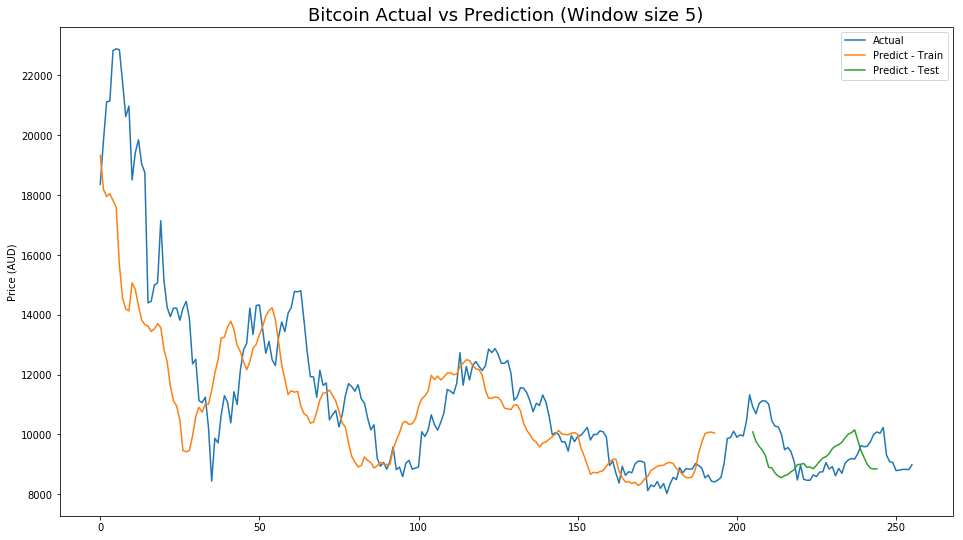

In [25]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(bitcoin_array)
trainPredictPlot[:, :] = np.nan
for i in range(0, len(trainPredict), 1):
    trainPredictPlot[(len(bitcoin_array)-max_threshold-test_threshold)+i] = trainPredict[i]
testPredictPlot = np.empty_like(bitcoin_array)
testPredictPlot[:, :] = np.nan
for i in range(0, len(testPredict), 1):
    testPredictPlot[(len(bitcoin_array)-test_threshold)+i] = testPredict[i]

# Revert back to relevant periods
bitcoin_array_plot = bitcoin_array[(len(bitcoin_array)-max_threshold-test_threshold):len(bitcoin_array)]
trainPredictPlot = trainPredictPlot[(len(trainPredictPlot)-max_threshold-test_threshold):]
testPredictPlot = testPredictPlot[(len(testPredictPlot)-max_threshold-test_threshold):]
plt.subplots(figsize=(16,9))
plt.plot(scaler.inverse_transform(bitcoin_array_plot), label="Actual")
plt.plot(trainPredictPlot, label="Predict - Train")
plt.plot(testPredictPlot, label="Predict - Test")
plt.title("Bitcoin Actual vs Prediction (Window size 30)", fontsize=18); plt.xlabel(""); plt.ylabel("Price (AUD)")
plt.legend(loc="upper right")
plt.show()

We observe that increasing the window creates a smoother function and is more realistic for understanding the overall volatility trends.

Note that the root mean square error is **higher** with larger window compared to a lower window.

It seems the prediction is just the value shifted back look_back days, and there is a gap between them.

# Stateful 2_layer LSTMs

In [28]:
import theano

https://www.youtube.com/watch?v=ywinX5wgdEU&lc=z232xtlxsxafcrgldacdp432thqwrab22ki2fx4m40pw03c010c.1536797127181524

The reason I do loop = 200 instead of epochs=200 is so that I can reset the states before moving on to the next epoch. Otherwise it will pass on the cell states from the last time step to the last one. Hope this helps.

** though I'm still not fully understood.**

In [40]:
%%time
theano.config.compute_test_value = "ignore"
# create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, batch_input_shape=(batch_size, look_back, 1), stateful=True))
model.add(Dropout(0.3))
model.add(Dense(194,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(output_dim = 1,activation='linear'))

CPU times: user 483 ms, sys: 13.4 ms, total: 496 ms
Wall time: 501 ms


/Users/libaisun/virtual/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="linear", units=1)`
  # This is added back by InteractiveShellApp.init_path()


In [41]:
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(200):
    model.fit(trainX, trainY, nb_epoch=10, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()

/Users/libaisun/virtual/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: Error when checking target: expected dense_12 to have shape (1,) but got array with shape (194,)

#### Reference:

https://github.com/sachinruk/PyData_Keras_Talk/blob/master/cosine_LSTM.ipynb